# Non-sequential pipelining

## What are non-sequential pipelines
TODO: Image


## Need for non-sequential pipelines
TODO take one or two examples for sktime issue


## Concept for realising non-sequential pipelines

* Under development:
* How to execute example
* Need some non merged branches
    * pyWATTS (master branch)
    * pyWATTS pipeline (sktime_integration branch)



In [1]:
# import numpy and pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Import Calendar feature Extraction from pyWATTS
from pywatts.modules import CalendarExtraction, CalendarFeature, SKLearnWrapper, Ensemble, FunctionModule
# Import sklearn Preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# Import sktime models
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import ARIMA

# Import non-sequential pipeline from pyWATTS
from pywatts_pipeline.core.pipeline import Pipeline
from pywatts_pipeline.core.util.computation_mode import ComputationMode
from pywatts_pipeline.utils._xarray_time_series_utils import numpy_to_xarray

C:\Users\bi4372\.conda\envs\pywatts_workshop\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bi4372\.conda\envs\pywatts_workshop\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\bi4372\.conda\envs\pywatts_workshop\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Considered non-sequential workflow example, describe it a bit

## Structure of the example non-sequential workflow
Create an image for visualizing this non-sequential workflow

* Input Data -> Scaler
* Input Data -> CalendarFeature
* CalendarFeature + Scaler -> Lineare Regression
* Lineare Regression -> InverseScaledLR
* InputData, Calendar -> ARIMA Forecast
* InputData -> ETS Forecast
* ARIMA Forecast + InverseScaledLR + ETS-> EnsembleForecast
* EnsembleForecast -> Price Forecast



Perhaps Price Forecast based on the Ensemble Model prediction and the calendar feature by using a Linear Regression?
<img src="img/non-sequential-pipeline.png" alt="Non Sequential Pipelien" width="1000"/>


## Define pipeline structure
* Pipeline object has an `add` method
    * First Parameter: Transformer/Forecaster
    * Second Parameter: name
    * Third Parameter: Inputs

In [12]:
pipeline = Pipeline(path="../results")

# Extract dummy calendar features, using holidays from Germany
# NOTE: CalendarExtraction can't return multiple features.
calendar = CalendarExtraction(continent="Europe",
                              country="Germany",
                              features=[CalendarFeature.month_sine,
                                        CalendarFeature.month_cos,
                                        CalendarFeature.weekday,
                                        CalendarFeature.weekend,
                                        CalendarFeature.hour_cos,
                                        CalendarFeature.hour_sine]
                              )
power_scaler = SKLearnWrapper(module=StandardScaler(), name="scaler_power")
regressor_power_statistics = SKLearnWrapper(module=LinearRegression(fit_intercept=True))

# TODO change it that here "time" is possible!
pipeline.add_new_api(calendar, "calendar", {"x": "time"})
pipeline.add_new_api(power_scaler, "power_scaler",
                     {"x": "load_power_statistics"})
pipeline.add_new_api(regressor_power_statistics,
                     "regressor_power_statistics",
                     {"cal": "calendar", "target": "power_scaler"},
                     )
pipeline.add_new_api(power_scaler, "power_scaler_inverse",
                     {"x": "regressor_power_statistics"},
                     method="inverse_transform")

pipeline.add_new_api(ARIMA(), "ARIMA",
                     {"y": "load_power_statistics",
                      "X": "calendar",
                      },
                     )
pipeline.add_new_api(AutoETS(), "ETS",
                     {"y": "load_power_statistics",}
                     )
pipeline.add_new_api(FunctionModule(lambda x: numpy_to_xarray(x.values.reshape((-1, 1)), x)),
                     "reshapedETS", {"x": "ETS"})
pipeline.add_new_api(FunctionModule(lambda x: numpy_to_xarray(x.values.reshape((-1, 1)), x)),
                     "reshapedARIMA", {"x": "ARIMA"})

pipeline.add_new_api(power_scaler, "inverse_lr", {"x": "regressor_power_statistics"},
                     computation_mode=ComputationMode.Transform,
                     use_inverse_transform=True,
                     method="inverse_transform"
                     )

pipeline.add_new_api(Ensemble(), "ensemble_forecast", {"x": "inverse_lr", "x2": "reshapedETS",
                                                       "x3": "reshapedARIMA",
                                                       "target": "load_power_statistics"},
                     )

# TODO richtiges verschieben mit ClockShift?

pipeline.add_new_api(SKLearnWrapper(name="LR Price", module=LinearRegression()), "LR Price",
                     {"x": "ensemble_forecast", "cal": "calendar", "target": "price_day_ahead"},
                     )


## Load Data, Train, and Predict with the Pipeline

In [20]:
data = pd.read_csv("data/getting_started_data.csv",
                   index_col="time",
                   parse_dates=["time"],
                   infer_datetime_format=True,
                   sep=",")
data = data.asfreq(pd.infer_freq(data.index))

train = data.iloc[:1000, :]

result = pipeline.train(data=train)

C:\Users\bi4372\PycharmProjects\pywatts-pipeline\pywatts_pipeline\core\steps\step.py:203: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  inputs[key] = inputs[key].rename({
C:\Users\bi4372\PycharmProjects\pywatts-pipeline\pywatts_pipeline\core\steps\step.py:220: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  inputs[key] = inputs[key].rename({
C:\Users\bi4372\PycharmProjects\pywatts-pipeline\pywatts_pipeline\core\steps\step.py:203: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  inputs[key] = inputs[key].rename({
C:\Users\bi4372\PycharmProjects\pywatts-pipeline\pywatts_pipeline\core\steps\step.py:220: UserWarning: rename 'time' to 'time' does n

Execute and predict with the pipeline

C:\Users\bi4372\PycharmProjects\pywatts-pipeline\pywatts_pipeline\core\steps\step.py:203: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  inputs[key] = inputs[key].rename({
C:\Users\bi4372\PycharmProjects\pywatts-pipeline\pywatts_pipeline\core\steps\step.py:220: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  inputs[key] = inputs[key].rename({
C:\Users\bi4372\PycharmProjects\pywatts-pipeline\pywatts_pipeline\core\steps\step.py:203: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  inputs[key] = inputs[key].rename({
C:\Users\bi4372\PycharmProjects\pywatts-pipeline\pywatts_pipeline\core\steps\step.py:220: UserWarning: rename 'time' to 'time' does n

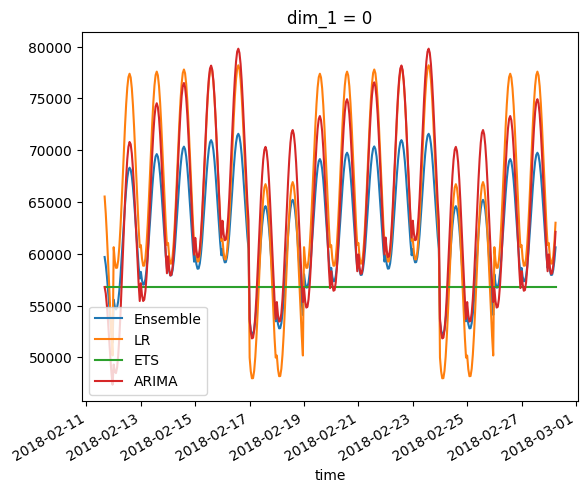

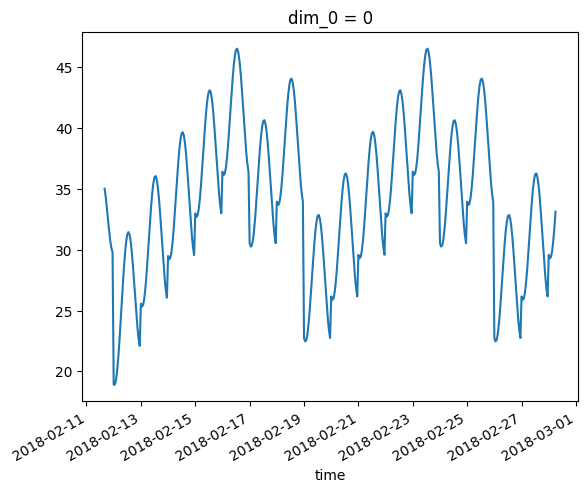

In [26]:
test = data.iloc[1000:1024]
test.drop("load_power_statistics", axis=1)

# TODO try to transform/predict instead of test!
result, _ = pipeline.test(data=test[: 24], fh=ForecastingHorizon(np.arange(1, 400), freq="1h"))
pipeline.get_step("ensemble_forecast", pipeline.assembled_steps).step.buffer["ensemble_forecast"].plot(label="Ensemble")
pipeline.get_step("inverse_lr", pipeline.assembled_steps).step.buffer["inverse_lr"].plot(label="LR")
pipeline.get_step("ETS", pipeline.assembled_steps).step.buffer["ETS"].plot(label="ETS")
pipeline.get_step("ARIMA", pipeline.assembled_steps).step.buffer["ARIMA"].plot(label="ARIMA")
plt.legend()
plt.show()
plt.close()
ax = result["target"].plot(label="LR Price Forecast")


# TODOs
* Use predict/transform instead of train
* Make things inside of the pipeline prettier
* Rename add_api_new
* Reduce the warnings, fix the corresponding issues
* Can we change the key target to price?
* Add images for:
    * Explaining non-sequential workflows
    * Showing the example pipeline we consider in the tutorial
* What is the problem with a gap between training and test data? Ensemble seems to make some problems...
* Improve the forecasting quality of all models!
